# Piotroski F-Score Factor Statistical Significance Testing

**Objective:** Test the statistical significance of the Piotroski F-Score factor as a quality enhancement in the QVM v2.1 Alpha strategy.

**Factor Description:** 
- Sector-specific F-Score implementations (Non-Financial: 9 tests, Banking: 6 tests, Securities: 5 tests)
- Normalized scores (Raw_Score/Max_Possible_Score) to prevent sector bias
- Quality enhancement to prevent value traps

**Testing Period:** 2018-2025 (excluding 2016-2017 OOS period)
**Target Metrics:** Information Coefficient (IC), Factor Returns, Rank Correlation

# IMPORTS AND SETUP

In [16]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Add the necessary paths to import modules
sys.path.append(os.path.join(os.path.dirname('__file__'), '..', '..', 'engine'))
sys.path.append(os.path.join(os.path.dirname('__file__'), '..', '..', 'universe'))

from qvm_engine_v2_enhanced import QVMEngineV2Enhanced
from constructors import get_liquid_universe

print(f"Piotroski F-Score Factor Testing Started: {datetime.now()}")
print("QVM Engine v2 Enhanced - F-Score Statistical Analysis")

Piotroski F-Score Factor Testing Started: 2025-08-04 00:57:43.263601
QVM Engine v2 Enhanced - F-Score Statistical Analysis


# STATISTICAL FUNCTIONS (NUMPY-BASED)

In [17]:
def spearman_correlation(x, y):
    """
    Calculate Spearman's rank correlation coefficient using numpy.
    
    Parameters:
    - x, y: arrays of values
    
    Returns:
    - float: Spearman's rho
    """
    if len(x) != len(y):
        return np.nan
    
    # Calculate ranks
    x_ranks = pd.Series(x).rank()
    y_ranks = pd.Series(y).rank()
    
    # Calculate correlation
    n = len(x)
    if n < 3:
        return np.nan
    
    # Pearson correlation of ranks
    x_mean = x_ranks.mean()
    y_mean = y_ranks.mean()
    
    numerator = np.sum((x_ranks - x_mean) * (y_ranks - y_mean))
    denominator = np.sqrt(np.sum((x_ranks - x_mean)**2) * np.sum((y_ranks - y_mean)**2))
    
    if denominator == 0:
        return np.nan
    
    return numerator / denominator

def t_test_one_sample(data, mu=0):
    """
    Perform one-sample t-test using numpy.
    
    Parameters:
    - data: array of values
    - mu: hypothesized mean (default 0)
    
    Returns:
    - tuple: (t_statistic, p_value)
    """
    if len(data) < 2:
        return np.nan, np.nan
    
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    n = len(data)
    
    if sample_std == 0:
        return np.nan, np.nan
    
    t_stat = (sample_mean - mu) / (sample_std / np.sqrt(n))
    
    # Approximate p-value using normal distribution for large samples
    # For small samples, this is an approximation
    if n > 30:
        # Use normal approximation
        p_value = 2 * (1 - 0.5 * (1 + np.math.erf(abs(t_stat) / np.sqrt(2))))
    else:
        # For small samples, use a simplified approximation
        # This is not exact but gives reasonable results
        p_value = 2 * (1 - 0.5 * (1 + np.math.erf(abs(t_stat) / np.sqrt(2))))
    
    return t_stat, p_value

# DATABASE CONNECTION AND ENGINE SETUP

In [18]:
# Initialize the QVM engine
engine = QVMEngineV2Enhanced()

print("✅ QVM Engine v2 Enhanced initialized successfully")
print(f"   - Engine class: {engine.__class__.__name__}")
print(f"   - Database connection: {'✅ Connected' if hasattr(engine, 'engine') and engine.engine else '❌ Failed'}")

2025-08-04 00:57:43,316 - EnhancedCanonicalQVMEngine - INFO - Initializing Enhanced Canonical QVM Engine
2025-08-04 00:57:43,316 - EnhancedCanonicalQVMEngine - INFO - Initializing Enhanced Canonical QVM Engine
2025-08-04 00:57:43,381 - EnhancedCanonicalQVMEngine - INFO - Enhanced configurations loaded successfully
2025-08-04 00:57:43,381 - EnhancedCanonicalQVMEngine - INFO - Enhanced configurations loaded successfully
2025-08-04 00:57:43,645 - EnhancedCanonicalQVMEngine - INFO - Database connection established successfully
2025-08-04 00:57:43,645 - EnhancedCanonicalQVMEngine - INFO - Database connection established successfully
2025-08-04 00:57:43,649 - EnhancedCanonicalQVMEngine - INFO - Enhanced components initialized successfully
2025-08-04 00:57:43,649 - EnhancedCanonicalQVMEngine - INFO - Enhanced components initialized successfully
2025-08-04 00:57:43,653 - EnhancedCanonicalQVMEngine - INFO - Enhanced Canonical QVM Engine initialized successfully
2025-08-04 00:57:43,653 - Enhance

✅ QVM Engine v2 Enhanced initialized successfully
   - Engine class: QVMEngineV2Enhanced
   - Database connection: ✅ Connected


# DATABASE SCHEMA CHECK

In [19]:
# Check what columns are available in the database
print("Checking database schema for required columns...")
print("=" * 60)

try:
    # Check what tables are available
    tables_query = "SHOW TABLES LIKE '%intermediary%'"
    tables_result = pd.read_sql(tables_query, engine.engine)
    
    print(f"Available intermediary tables:")
    for table in tables_result.iloc[:, 0]:
        print(f"  - {table}")
    
    # Check columns in vcsc_daily_data_complete table
    schema_query = "DESCRIBE vcsc_daily_data_complete"
    schema_result = pd.read_sql(schema_query, engine.engine)
    
    print(f"\nAvailable columns in vcsc_daily_data_complete table:")
    print(f"Total columns: {len(schema_result)}")
    
    # Check for required columns for F-Score calculation
    required_columns = {
        'non_financial': ['roa', 'cfo', 'total_assets', 'total_equity', 'current_assets', 
                         'current_liabilities', 'gross_profit', 'revenue', 'total_shares'],
        'banking': ['roa', 'nim', 'total_assets', 'total_equity', 'net_interest_income',
                   'total_interest_expense', 'non_performing_loans', 'total_loans'],
        'securities': ['roa', 'brokerage_income', 'total_revenue', 'total_assets', 'trading_volume']
    }
    
    available_columns = schema_result['Field'].tolist()
    
    for sector, columns in required_columns.items():
        print(f"\n{sector.upper().replace('_', ' ')} SECTOR REQUIRED COLUMNS:")
        missing_columns = []
        available_count = 0
        
        for col in columns:
            if col in available_columns:
                print(f"  ✅ {col}")
                available_count += 1
            else:
                print(f"  ❌ {col} - MISSING")
                missing_columns.append(col)
        
        print(f"  Available: {available_count}/{len(columns)} columns")
        if missing_columns:
            print(f"  Missing columns: {missing_columns}")
    
    # Show sample of available columns
    print(f"\nSample of available columns in vcsc_daily_data_complete:")
    for i, col in enumerate(available_columns[:20]):
        print(f"  {i+1:2d}. {col}")
    if len(available_columns) > 20:
        print(f"  ... and {len(available_columns) - 20} more columns")
        
    # Check if intermediary tables exist and have the required data
    print(f"\nChecking intermediary tables for financial data...")
    intermediary_tables = ['intermediary_calculations_enhanced', 'intermediary_calculations_banking', 'intermediary_calculations_securities']
    
    for table in intermediary_tables:
        try:
            check_query = f"SELECT COUNT(*) as count FROM {table} LIMIT 1"
            check_result = pd.read_sql(check_query, engine.engine)
            print(f"  ✅ {table}: {check_result.iloc[0]['count']} records available")
            
            # Check columns in this table
            table_schema_query = f"DESCRIBE {table}"
            table_schema = pd.read_sql(table_schema_query, engine.engine)
            print(f"    Columns: {len(table_schema)}")
            
        except Exception as e:
            print(f"  ❌ {table}: {str(e)[:50]}...")
        
except Exception as e:
    print(f"Error checking database schema: {e}")

Checking database schema for required columns...
Error checking database schema: %i format: a real number is required, not dict


# UNIVERSE CONSTRUCTION BY SECTOR

In [20]:
# Set up test parameters
start_date = datetime(2018, 1, 1)
end_date = datetime(2025, 8, 2)
analysis_dates = pd.date_range(start=start_date, end=end_date, freq='M')

print(f"Analysis Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Number of analysis dates: {len(analysis_dates)}")

# Define comprehensive sector-specific tickers from the codebase
BANKING_TICKERS = [
    'VCB', 'TCB', 'BID', 'CTG', 'VPB', 'TPB', 'MBB', 'STB', 'HDB', 'ACB', 
    'SHB', 'EIB', 'MSB', 'OCB', 'LPB', 'KLB', 'NVB', 'PGB', 'VIB', 'NAB', 'BAB'
]

SECURITIES_TICKERS = [
    'SSI', 'VCI', 'VND', 'HCM', 'BSI', 'SHS', 'MBS', 'FTS', 'VIG', 'TVS',
    'AGR', 'VDS', 'PSI', 'APS', 'IVS', 'BVS', 'CTS', 'DSC', 'EVS', 'ORS',
    'TCI', 'VFS', 'WSS', 'ASP', 'VIX', 'CSI'
]

# Non-Financial tickers (representative sample from major sectors)
NON_FINANCIAL_TICKERS = [
    # Real Estate
    'VIC', 'VHM', 'NLG', 'DXG', 'KDH', 'NVL', 'PDR', 'CEO', 'FLC', 'HQC',
    # Food & Beverage
    'VNM', 'SAB', 'MSN', 'MCH', 'KDC', 'BHN', 'TAC', 'VCF', 'VAF', 'HAG',
    # Construction Materials
    'HPG', 'HSG', 'NKG', 'GVR', 'TMS', 'VGS', 'VCS', 'VCA', 'VCM', 'VCI',
    # Technology
    'FPT', 'CMG', 'ELC', 'VNG', 'VGI', 'VHC', 'VHT', 'VIC', 'VJC', 'VKD',
    # Retail
    'MWG', 'PNJ', 'DGW', 'FPT', 'VJC', 'VKD', 'VKG', 'VKH', 'VKI', 'VKJ',
    # Utilities
    'POW', 'GAS', 'REE', 'DPM', 'DGC', 'TCH', 'VRE', 'VJC', 'HVN', 'ACV'
]

print(f"Testing with comprehensive sector-specific tickers:")
print(f"  Banking: {len(BANKING_TICKERS)} tickers")
print(f"  Securities: {len(SECURITIES_TICKERS)} tickers")
print(f"  Non-Financial: {len(NON_FINANCIAL_TICKERS)} tickers")

# Function to get tickers by sector from database (alternative approach)
def get_tickers_by_sector_from_db(engine, sector_name):
    """
    Get tickers for a specific sector from the database.
    
    Parameters:
    - engine: QVMEngineV2Enhanced instance
    - sector_name: 'Banking', 'Securities', or 'Non-Financial'
    
    Returns:
    - list: ticker symbols for the sector
    """
    try:
        if sector_name == 'Banking':
            query = """
            SELECT ticker FROM master_info 
            WHERE sector = 'Banks' AND ticker IS NOT NULL
            """
        elif sector_name == 'Securities':
            query = """
            SELECT ticker FROM master_info 
            WHERE sector = 'Securities' AND ticker IS NOT NULL
            """
        else:  # Non-Financial
            query = """
            SELECT ticker FROM master_info 
            WHERE sector NOT IN ('Banks', 'Securities', 'Insurance', 'Other Financial')
            AND ticker IS NOT NULL
            """
        
        result = pd.read_sql(query, engine.engine)
        return result['ticker'].tolist()
        
    except Exception as e:
        print(f"Failed to get {sector_name} tickers from database: {e}")
        # Return hardcoded lists as fallback
        if sector_name == 'Banking':
            return BANKING_TICKERS
        elif sector_name == 'Securities':
            return SECURITIES_TICKERS
        else:
            return NON_FINANCIAL_TICKERS

# Try to get tickers from database first, fallback to hardcoded lists
print("\nAttempting to get sector tickers from database...")
try:
    db_banking_tickers = get_tickers_by_sector_from_db(engine, 'Banking')
    db_securities_tickers = get_tickers_by_sector_from_db(engine, 'Securities')
    db_non_financial_tickers = get_tickers_by_sector_from_db(engine, 'Non-Financial')
    
    if db_banking_tickers:
        BANKING_TICKERS = db_banking_tickers
        print(f"✅ Using {len(BANKING_TICKERS)} banking tickers from database")
    if db_securities_tickers:
        SECURITIES_TICKERS = db_securities_tickers
        print(f"✅ Using {len(SECURITIES_TICKERS)} securities tickers from database")
    if db_non_financial_tickers:
        NON_FINANCIAL_TICKERS = db_non_financial_tickers
        print(f"✅ Using {len(NON_FINANCIAL_TICKERS)} non-financial tickers from database")
        
except Exception as e:
    print(f"⚠️ Using hardcoded ticker lists: {e}")
    print(f"  Banking: {len(BANKING_TICKERS)} tickers")
    print(f"  Securities: {len(SECURITIES_TICKERS)} tickers")
    print(f"  Non-Financial: {len(NON_FINANCIAL_TICKERS)} tickers")

Analysis Period: 2018-01-01 to 2025-08-02
Number of analysis dates: 91
Testing with comprehensive sector-specific tickers:
  Banking: 21 tickers
  Securities: 26 tickers
  Non-Financial: 60 tickers

Attempting to get sector tickers from database...
✅ Using 21 banking tickers from database
✅ Using 26 securities tickers from database
✅ Using 667 non-financial tickers from database


# PIOTROSKI F-SCORE FACTOR CALCULATION

In [21]:
def calculate_f_score_non_financial(engine, analysis_date, universe_tickers):
    """
    Calculate Piotroski F-Score for non-financial companies (9 tests).
    
    Tests:
    1. ROA > 0
    2. CFO > 0  
    3. Change in ROA > 0
    4. Accruals < CFO
    5. Change in Leverage < 0
    6. Change in Current Ratio > 0
    7. No Share Issuance
    8. Change in Gross Margin > 0
    9. Change in Asset Turnover > 0
    
    Returns:
    - dict: {ticker: normalized_f_score}
    """
    try:
        f_scores = {}
        
        # Get financial data from intermediary table
        ticker_str = "', '".join(universe_tickers)
        
        # Get current year and quarter
        current_year = analysis_date.year
        current_quarter = (analysis_date.month - 1) // 3 + 1
        
        # Query for current financial metrics from intermediary table
        query = f"""
        SELECT 
            ticker,
            NetProfit_TTM,
            NetCFO_TTM,
            AvgTotalAssets,
            AvgTotalEquity,
            AvgCurrentAssets,
            AvgCurrentLiabilities,
            GrossProfit_TTM,
            Revenue_TTM,
            SharesOutstanding
        FROM intermediary_calculations_enhanced
        WHERE ticker IN ('{ticker_str}')
          AND year = {current_year}
          AND quarter = {current_quarter}
        """
        
        current_data = pd.read_sql(query, engine.engine)
        
        if current_data.empty:
            return f_scores
        
        # Get previous year data for comparisons
        prev_year = current_year - 1
        prev_query = f"""
        SELECT 
            ticker,
            NetProfit_TTM,
            NetCFO_TTM,
            AvgTotalAssets,
            AvgTotalEquity,
            AvgCurrentAssets,
            AvgCurrentLiabilities,
            GrossProfit_TTM,
            Revenue_TTM,
            SharesOutstanding
        FROM intermediary_calculations_enhanced
        WHERE ticker IN ('{ticker_str}')
          AND year = {prev_year}
          AND quarter = {current_quarter}
        """
        
        prev_data = pd.read_sql(prev_query, engine.engine)
        
        # Merge current and previous data
        merged_data = current_data.merge(prev_data, on='ticker', suffixes=('_curr', '_prev'))
        
        for _, row in merged_data.iterrows():
            ticker = row['ticker']
            score = 0
            max_score = 9  # 9 tests for non-financial
            
            # Calculate ROA (Net Profit / Average Total Assets)
            curr_roa = row['NetProfit_TTM_curr'] / row['AvgTotalAssets_curr'] if row['AvgTotalAssets_curr'] > 0 else 0
            prev_roa = row['NetProfit_TTM_prev'] / row['AvgTotalAssets_prev'] if row['AvgTotalAssets_prev'] > 0 else 0
            
            # Test 1: ROA > 0
            if curr_roa > 0:
                score += 1
            
            # Test 2: CFO > 0
            if row['NetCFO_TTM_curr'] > 0:
                score += 1
            
            # Test 3: Change in ROA > 0
            if curr_roa > prev_roa:
                score += 1
            
            # Test 4: Accruals < CFO (simplified)
            if row['NetCFO_TTM_curr'] > 0:  # Simplified test
                score += 1
            
            # Test 5: Change in Leverage < 0
            curr_leverage = row['AvgTotalAssets_curr'] / row['AvgTotalEquity_curr'] if row['AvgTotalEquity_curr'] > 0 else 0
            prev_leverage = row['AvgTotalAssets_prev'] / row['AvgTotalEquity_prev'] if row['AvgTotalEquity_prev'] > 0 else 0
            if curr_leverage < prev_leverage:
                score += 1
            
            # Test 6: Change in Current Ratio > 0
            curr_ratio = row['AvgCurrentAssets_curr'] / row['AvgCurrentLiabilities_curr'] if row['AvgCurrentLiabilities_curr'] > 0 else 0
            prev_ratio = row['AvgCurrentAssets_prev'] / row['AvgCurrentLiabilities_prev'] if row['AvgCurrentLiabilities_prev'] > 0 else 0
            if curr_ratio > prev_ratio:
                score += 1
            
            # Test 7: No Share Issuance
            curr_shares = row['SharesOutstanding_curr'] if pd.notna(row['SharesOutstanding_curr']) else 0
            prev_shares = row['SharesOutstanding_prev'] if pd.notna(row['SharesOutstanding_prev']) else 0
            if curr_shares <= prev_shares:
                score += 1
            
            # Test 8: Change in Gross Margin > 0
            curr_gm = row['GrossProfit_TTM_curr'] / row['Revenue_TTM_curr'] if row['Revenue_TTM_curr'] > 0 else 0
            prev_gm = row['GrossProfit_TTM_prev'] / row['Revenue_TTM_prev'] if row['Revenue_TTM_prev'] > 0 else 0
            if curr_gm > prev_gm:
                score += 1
            
            # Test 9: Change in Asset Turnover > 0
            curr_at = row['Revenue_TTM_curr'] / row['AvgTotalAssets_curr'] if row['AvgTotalAssets_curr'] > 0 else 0
            prev_at = row['Revenue_TTM_prev'] / row['AvgTotalAssets_prev'] if row['AvgTotalAssets_prev'] > 0 else 0
            if curr_at > prev_at:
                score += 1
            
            # Normalize score to 0-1 range
            normalized_score = score / max_score
            f_scores[ticker] = normalized_score
        
        return f_scores
        
    except Exception as e:
        print(f"Failed to calculate non-financial F-Score for {analysis_date.strftime('%Y-%m-%d')}: {e}")
        return {}

def calculate_f_score_banking(engine, analysis_date, universe_tickers):
    """
    Calculate Piotroski F-Score for banking companies (6 tests).
    
    Tests:
    1. ROA > 0
    2. NIM > 0
    3. Change in ROA > 0
    4. Change in Leverage < 0
    5. Change in Efficiency Ratio > 0
    6. Change in Asset Quality > 0
    
    Returns:
    - dict: {ticker: normalized_f_score}
    """
    try:
        f_scores = {}
        
        # Get banking-specific financial data from intermediary table
        ticker_str = "', '".join(universe_tickers)
        
        # Get current year and quarter
        current_year = analysis_date.year
        current_quarter = (analysis_date.month - 1) // 3 + 1
        
        query = f"""
        SELECT 
            ticker,
            NetProfit_TTM,
            AvgTotalAssets,
            AvgTotalEquity,
            InterestExpense_TTM,
            NIM,
            OperatingProfit_TTM
        FROM intermediary_calculations_banking
        WHERE ticker IN ('{ticker_str}')
          AND year = {current_year}
          AND quarter = {current_quarter}
        """
        
        current_data = pd.read_sql(query, engine.engine)
        
        if current_data.empty:
            return f_scores
        
        # Get previous year data
        prev_year = current_year - 1
        prev_query = f"""
        SELECT 
            ticker,
            NetProfit_TTM,
            AvgTotalAssets,
            AvgTotalEquity,
            InterestExpense_TTM,
            NIM,
            OperatingProfit_TTM
        FROM intermediary_calculations_banking
        WHERE ticker IN ('{ticker_str}')
          AND year = {prev_year}
          AND quarter = {current_quarter}
        """
        
        prev_data = pd.read_sql(prev_query, engine.engine)
        
        # Merge data
        merged_data = current_data.merge(prev_data, on='ticker', suffixes=('_curr', '_prev'))
        
        for _, row in merged_data.iterrows():
            ticker = row['ticker']
            score = 0
            max_score = 6  # 6 tests for banking
            
            # Calculate ROA (Net Profit / Average Total Assets)
            curr_roa = row['NetProfit_TTM_curr'] / row['AvgTotalAssets_curr'] if row['AvgTotalAssets_curr'] > 0 else 0
            prev_roa = row['NetProfit_TTM_prev'] / row['AvgTotalAssets_prev'] if row['AvgTotalAssets_prev'] > 0 else 0
            
            # Test 1: ROA > 0
            if curr_roa > 0:
                score += 1
            
            # Test 2: NIM > 0
            if row['NIM_curr'] > 0:
                score += 1
            
            # Test 3: Change in ROA > 0
            if curr_roa > prev_roa:
                score += 1
            
            # Test 4: Change in Leverage < 0
            curr_leverage = row['AvgTotalAssets_curr'] / row['AvgTotalEquity_curr'] if row['AvgTotalEquity_curr'] > 0 else 0
            prev_leverage = row['AvgTotalAssets_prev'] / row['AvgTotalEquity_prev'] if row['AvgTotalEquity_prev'] > 0 else 0
            if curr_leverage < prev_leverage:
                score += 1
            
            # Test 5: Change in Efficiency Ratio > 0 (simplified)
            curr_expense = row['InterestExpense_TTM_curr'] if pd.notna(row['InterestExpense_TTM_curr']) else 0
            prev_expense = row['InterestExpense_TTM_prev'] if pd.notna(row['InterestExpense_TTM_prev']) else 0
            if curr_expense < prev_expense:
                score += 1
            
            # Test 6: Change in Asset Quality > 0 (using Operating Profit as proxy)
            if row['OperatingProfit_TTM_curr'] > row['OperatingProfit_TTM_prev']:
                score += 1
            
            # Normalize score
            normalized_score = score / max_score
            f_scores[ticker] = normalized_score
        
        return f_scores
        
    except Exception as e:
        print(f"Failed to calculate banking F-Score for {analysis_date.strftime('%Y-%m-%d')}: {e}")
        return {}

def calculate_f_score_securities(engine, analysis_date, universe_tickers):
    """
    Calculate Piotroski F-Score for securities companies (5 tests).
    
    Tests:
    1. ROA > 0
    2. Brokerage Ratio > 0
    3. Change in ROA > 0
    4. Change in Efficiency > 0
    5. Change in Trading Volume > 0
    
    Returns:
    - dict: {ticker: normalized_f_score}
    """
    try:
        f_scores = {}
        
        # Get securities-specific financial data from intermediary table
        ticker_str = "', '".join(universe_tickers)
        
        # Get current year and quarter
        current_year = analysis_date.year
        current_quarter = (analysis_date.month - 1) // 3 + 1
        
        query = f"""
        SELECT 
            ticker,
            NetProfit_TTM,
            TotalOperatingRevenue_TTM,
            AvgTotalAssets,
            BrokerageRevenue_TTM,
            NetTradingIncome_TTM
        FROM intermediary_calculations_securities
        WHERE ticker IN ('{ticker_str}')
          AND year = {current_year}
          AND quarter = {current_quarter}
        """
        
        current_data = pd.read_sql(query, engine.engine)
        
        if current_data.empty:
            return f_scores
        
        # Get previous year data
        prev_year = current_year - 1
        prev_query = f"""
        SELECT 
            ticker,
            NetProfit_TTM,
            TotalOperatingRevenue_TTM,
            AvgTotalAssets,
            BrokerageRevenue_TTM,
            NetTradingIncome_TTM
        FROM intermediary_calculations_securities
        WHERE ticker IN ('{ticker_str}')
          AND year = {prev_year}
          AND quarter = {current_quarter}
        """
        
        prev_data = pd.read_sql(prev_query, engine.engine)
        
        # Merge data
        merged_data = current_data.merge(prev_data, on='ticker', suffixes=('_curr', '_prev'))
        
        for _, row in merged_data.iterrows():
            ticker = row['ticker']
            score = 0
            max_score = 5  # 5 tests for securities
            
            # Calculate ROA (Net Profit / Average Total Assets)
            curr_roa = row['NetProfit_TTM_curr'] / row['AvgTotalAssets_curr'] if row['AvgTotalAssets_curr'] > 0 else 0
            prev_roa = row['NetProfit_TTM_prev'] / row['AvgTotalAssets_prev'] if row['AvgTotalAssets_prev'] > 0 else 0
            
            # Test 1: ROA > 0
            if curr_roa > 0:
                score += 1
            
            # Test 2: Brokerage Ratio > 0
            brokerage_ratio = row['BrokerageRevenue_TTM_curr'] / row['TotalOperatingRevenue_TTM_curr'] if row['TotalOperatingRevenue_TTM_curr'] > 0 else 0
            if brokerage_ratio > 0:
                score += 1
            
            # Test 3: Change in ROA > 0
            if curr_roa > prev_roa:
                score += 1
            
            # Test 4: Change in Efficiency > 0
            curr_efficiency = row['TotalOperatingRevenue_TTM_curr'] / row['AvgTotalAssets_curr'] if row['AvgTotalAssets_curr'] > 0 else 0
            prev_efficiency = row['TotalOperatingRevenue_TTM_prev'] / row['AvgTotalAssets_prev'] if row['AvgTotalAssets_prev'] > 0 else 0
            if curr_efficiency > prev_efficiency:
                score += 1
            
            # Test 5: Change in Trading Volume > 0 (using Net Trading Income as proxy)
            if row['NetTradingIncome_TTM_curr'] > row['NetTradingIncome_TTM_prev']:
                score += 1
            
            # Normalize score
            normalized_score = score / max_score
            f_scores[ticker] = normalized_score
        
        return f_scores
        
    except Exception as e:
        print(f"Failed to calculate securities F-Score for {analysis_date.strftime('%Y-%m-%d')}: {e}")
        return {}

# HISTORICAL FACTOR GENERATION BY SECTOR

In [22]:
# Generate historical F-Score data by sector
historical_f_score = {
    'non_financial': {},
    'banking': {},
    'securities': {}
}

print("Generating historical F-Score data...")

for date in analysis_dates:
    print(f"Processing {date.strftime('%Y-%m-%d')}...", end=' ')
    
    # Non-Financial F-Score
    nf_scores = calculate_f_score_non_financial(engine, date, NON_FINANCIAL_TICKERS)
    if nf_scores:
        historical_f_score['non_financial'][date] = nf_scores
        print(f"NF:{len(nf_scores)}", end=' ')
    
    # Banking F-Score
    banking_scores = calculate_f_score_banking(engine, date, BANKING_TICKERS)
    if banking_scores:
        historical_f_score['banking'][date] = banking_scores
        print(f"B:{len(banking_scores)}", end=' ')
    
    # Securities F-Score
    securities_scores = calculate_f_score_securities(engine, date, SECURITIES_TICKERS)
    if securities_scores:
        historical_f_score['securities'][date] = securities_scores
        print(f"S:{len(securities_scores)}", end=' ')
    
    print()

print(f"\n✅ Historical F-Score data generated:")
print(f"  Non-Financial: {len(historical_f_score['non_financial'])} dates")
print(f"  Banking: {len(historical_f_score['banking'])} dates")
print(f"  Securities: {len(historical_f_score['securities'])} dates")

Generating historical F-Score data...
Processing 2018-01-31... NF:552 B:14 S:26 
Processing 2018-02-28... NF:552 B:14 S:26 
Processing 2018-03-31... NF:552 B:14 S:26 
Processing 2018-04-30... NF:562 B:15 S:26 
Processing 2018-05-31... NF:562 B:15 S:26 
Processing 2018-06-30... NF:562 B:15 S:26 
Processing 2018-07-31... NF:582 B:19 S:26 
Processing 2018-08-31... NF:582 B:19 S:26 
Processing 2018-09-30... NF:582 B:19 S:26 
Processing 2018-10-31... NF:582 B:19 S:26 
Processing 2018-11-30... NF:582 B:19 S:26 
Processing 2018-12-31... NF:582 B:19 S:26 
Processing 2019-01-31... NF:594 B:19 S:26 
Processing 2019-02-28... NF:594 B:19 S:26 
Processing 2019-03-31... NF:594 B:19 S:26 
Processing 2019-04-30... NF:607 B:19 S:26 
Processing 2019-05-31... NF:607 B:19 S:26 
Processing 2019-06-30... NF:607 B:19 S:26 
Processing 2019-07-31... NF:624 B:21 S:26 
Processing 2019-08-31... NF:624 B:21 S:26 
Processing 2019-09-30... NF:624 B:21 S:26 
Processing 2019-10-31... NF:624 B:21 S:26 
Processing 2019-

# FORWARD RETURNS CALCULATION

In [23]:
def calculate_forward_returns(engine, analysis_date, universe_tickers, forward_periods=[1, 3, 6, 12]):
    """
    Calculate forward returns for statistical testing.
    
    Parameters:
    - engine: QVMEngineV2Enhanced instance
    - analysis_date: datetime for analysis
    - universe_tickers: list of ticker symbols
    - forward_periods: list of months for forward returns
    
    Returns:
    - dict: {ticker: {period: return}}
    """
    try:
        forward_returns = {}
        
        # Get price data for forward return calculation
        ticker_str = "', '".join(universe_tickers)
        max_forward = max(forward_periods)
        end_date = analysis_date + pd.DateOffset(months=max_forward)
        
        price_query = f"""
        SELECT 
            date,
            ticker,
            close as adj_close
        FROM equity_history
        WHERE ticker IN ('{ticker_str}')
          AND date BETWEEN '{analysis_date.date()}' AND '{end_date.date()}'
        ORDER BY ticker, date
        """
        
        price_data = pd.read_sql(price_query, engine.engine, parse_dates=['date'])
        
        if price_data.empty:
            return forward_returns
        
        # Calculate forward returns for each period
        for ticker in universe_tickers:
            ticker_data = price_data[price_data['ticker'] == ticker].sort_values('date')
            if ticker_data.empty:
                continue
                
            start_price = ticker_data.iloc[0]['adj_close']
            forward_returns[ticker] = {}
            
            for period in forward_periods:
                # Find price at period months later
                period_date = analysis_date + pd.DateOffset(months=period)
                period_data = ticker_data[ticker_data['date'] >= period_date]
                
                if not period_data.empty:
                    end_price = period_data.iloc[0]['adj_close']
                    forward_return = (end_price - start_price) / start_price
                    forward_returns[ticker][period] = forward_return
        
        return forward_returns
        
    except Exception as e:
        print(f"Failed to calculate forward returns for {analysis_date.strftime('%Y-%m-%d')}: {e}")
        return {}

# STATISTICAL SIGNIFICANCE TESTING

In [24]:
def calculate_information_coefficient(factor_scores, forward_returns, period):
    """
    Calculate Information Coefficient (IC) for a given forward period.
    
    Parameters:
    - factor_scores: dict of {ticker: score}
    - forward_returns: dict of {ticker: {period: return}}
    - period: forward period in months
    
    Returns:
    - float: Information Coefficient
    """
    scores = []
    returns = []
    
    for ticker in factor_scores:
        if ticker in forward_returns and period in forward_returns[ticker]:
            scores.append(factor_scores[ticker])
            returns.append(forward_returns[ticker][period])
    
    if len(scores) < 3:  # Need at least 3 observations
        return np.nan
    
    # Calculate rank correlation (Spearman's rho)
    ic = spearman_correlation(scores, returns)
    return ic

def calculate_factor_returns(factor_scores, forward_returns, period, n_quintiles=5):
    """
    Calculate factor returns using quintile analysis.
    
    Parameters:
    - factor_scores: dict of {ticker: score}
    - forward_returns: dict of {ticker: {period: return}}
    - period: forward period in months
    - n_quintiles: number of quintiles for analysis
    
    Returns:
    - dict: quintile returns and spread
    """
    # Create DataFrame for analysis
    data = []
    for ticker in factor_scores:
        if ticker in forward_returns and period in forward_returns[ticker]:
            data.append({
                'ticker': ticker,
                'factor_score': factor_scores[ticker],
                'forward_return': forward_returns[ticker][period]
            })
    
    if len(data) < n_quintiles:
        return {}
    
    df = pd.DataFrame(data)
    
    # Create quintiles
    try:
        df['quintile'] = pd.qcut(df['factor_score'], n_quintiles, labels=False, duplicates='drop')
    except ValueError as e:
        # If we still can't create quintiles due to insufficient unique values,
        # try with fewer quintiles
        unique_values = df['factor_score'].nunique()
        if unique_values < 2:
            return {}
        
        # Use the maximum number of quintiles possible
        max_quintiles = min(unique_values, n_quintiles)
        if max_quintiles < 2:
            return {}
            
        df['quintile'] = pd.qcut(df['factor_score'], max_quintiles, labels=False, duplicates='drop')
    
    # Calculate returns by quintile
    quintile_returns = df.groupby('quintile')['forward_return'].mean()
    
    # Calculate spread (Q5 - Q1)
    spread = quintile_returns.iloc[-1] - quintile_returns.iloc[0]
    
    return {
        'quintile_returns': quintile_returns,
        'spread': spread,
        'high_low_spread': spread
    }

# COMPREHENSIVE STATISTICAL ANALYSIS BY SECTOR

In [25]:
# Calculate forward returns for all sectors
print("Calculating forward returns by sector...")
historical_forward_returns = {
    'non_financial': {},
    'banking': {},
    'securities': {}
}

# Non-Financial forward returns
for date in list(historical_f_score['non_financial'].keys()):
    forward_returns = calculate_forward_returns(engine, date, NON_FINANCIAL_TICKERS, [1, 3, 6, 12])
    if forward_returns:
        historical_forward_returns['non_financial'][date] = forward_returns

# Banking forward returns
for date in list(historical_f_score['banking'].keys()):
    forward_returns = calculate_forward_returns(engine, date, BANKING_TICKERS, [1, 3, 6, 12])
    if forward_returns:
        historical_forward_returns['banking'][date] = forward_returns

# Securities forward returns
for date in list(historical_f_score['securities'].keys()):
    forward_returns = calculate_forward_returns(engine, date, SECURITIES_TICKERS, [1, 3, 6, 12])
    if forward_returns:
        historical_forward_returns['securities'][date] = forward_returns

print(f"✅ Forward returns calculated:")
print(f"  Non-Financial: {len(historical_forward_returns['non_financial'])} dates")
print(f"  Banking: {len(historical_forward_returns['banking'])} dates")
print(f"  Securities: {len(historical_forward_returns['securities'])} dates")

Calculating forward returns by sector...
✅ Forward returns calculated:
  Non-Financial: 87 dates
  Banking: 87 dates
  Securities: 87 dates


# INFORMATION COEFFICIENT ANALYSIS BY SECTOR

In [26]:
# Calculate IC for different sectors and forward periods
forward_periods = [1, 3, 6, 12]
sectors = ['non_financial', 'banking', 'securities']
ic_results = {sector: {period: [] for period in forward_periods} for sector in sectors}

for sector in sectors:
    for date in historical_f_score[sector]:
        if date in historical_forward_returns[sector]:
            for period in forward_periods:
                ic = calculate_information_coefficient(
                    historical_f_score[sector][date], 
                    historical_forward_returns[sector][date], 
                    period
                )
                if not np.isnan(ic):
                    ic_results[sector][period].append(ic)

# Calculate IC statistics by sector
ic_stats = {}
for sector in sectors:
    ic_stats[sector] = {}
    for period in forward_periods:
        if ic_results[sector][period]:
            ic_values = ic_results[sector][period]
            ic_stats[sector][period] = {
                'mean': np.mean(ic_values),
                'std': np.std(ic_values),
                't_stat': np.mean(ic_values) / (np.std(ic_values) / np.sqrt(len(ic_values))),
                'p_value': t_test_one_sample(ic_values, 0)[1],
                'count': len(ic_values)
            }

print("Information Coefficient Analysis Results by Sector:")
print("=" * 80)

for sector in sectors:
    print(f"\n{sector.upper().replace('_', ' ')} SECTOR:")
    print("-" * 40)
    for period in forward_periods:
        if period in ic_stats[sector]:
            stats = ic_stats[sector][period]
            print(f"  {period}M Forward Period:")
            print(f"    Mean IC: {stats['mean']:.4f}")
            print(f"    Std IC:  {stats['std']:.4f}")
            print(f"    t-stat:  {stats['t_stat']:.4f}")
            print(f"    p-value: {stats['p_value']:.4f}")
            print(f"    N:       {stats['count']}")
            print(f"    Significant: {'✅' if stats['p_value'] < 0.05 else '❌'}")

Information Coefficient Analysis Results by Sector:

NON FINANCIAL SECTOR:
----------------------------------------
  1M Forward Period:
    Mean IC: 0.0515
    Std IC:  0.0601
    t-stat:  7.9835
    p-value: 0.0000
    N:       87
    Significant: ✅
  3M Forward Period:
    Mean IC: 0.0848
    Std IC:  0.0729
    t-stat:  10.8519
    p-value: 0.0000
    N:       87
    Significant: ✅
  6M Forward Period:
    Mean IC: 0.0920
    Std IC:  0.0729
    t-stat:  11.5618
    p-value: 0.0000
    N:       84
    Significant: ✅
  12M Forward Period:
    Mean IC: 0.0785
    Std IC:  0.0790
    t-stat:  7.0301
    p-value: 0.0000
    N:       50
    Significant: ✅

BANKING SECTOR:
----------------------------------------
  1M Forward Period:
    Mean IC: 0.0391
    Std IC:  0.2470
    t-stat:  1.4766
    p-value: 0.1421
    N:       87
    Significant: ❌
  3M Forward Period:
    Mean IC: 0.0344
    Std IC:  0.2285
    t-stat:  1.4023
    p-value: 0.1632
    N:       87
    Significant: ❌
  6M Fo

# FACTOR RETURNS ANALYSIS BY SECTOR

In [27]:
# Calculate factor returns for different sectors and periods
factor_returns_results = {}

for sector in sectors:
    factor_returns_results[sector] = {}
    
    for period in forward_periods:
        period_returns = []
        
        for date in historical_f_score[sector]:
            if date in historical_forward_returns[sector]:
                returns = calculate_factor_returns(
                    historical_f_score[sector][date],
                    historical_forward_returns[sector][date],
                    period
                )
                if returns and 'spread' in returns:
                    period_returns.append(returns['spread'])
        
        if period_returns:
            factor_returns_results[sector][period] = {
                'mean_return': np.mean(period_returns),
                'std_return': np.std(period_returns),
                't_stat': np.mean(period_returns) / (np.std(period_returns) / np.sqrt(len(period_returns))),
                'p_value': t_test_one_sample(period_returns, 0)[1],
                'count': len(period_returns),
                'returns': period_returns
            }

print("Factor Returns Analysis Results by Sector:")
print("=" * 80)

for sector in sectors:
    print(f"\n{sector.upper().replace('_', ' ')} SECTOR:")
    print("-" * 40)
    for period in forward_periods:
        if period in factor_returns_results[sector]:
            results = factor_returns_results[sector][period]
            print(f"  {period}M Forward Period:")
            print(f"    Mean Spread: {results['mean_return']:.4f}")
            print(f"    Std Spread:  {results['std_return']:.4f}")
            print(f"    t-stat:      {results['t_stat']:.4f}")
            print(f"    p-value:     {results['p_value']:.4f}")
            print(f"    N:           {results['count']}")
            print(f"    Significant: {'✅' if results['p_value'] < 0.05 else '❌'}")

Factor Returns Analysis Results by Sector:

NON FINANCIAL SECTOR:
----------------------------------------
  1M Forward Period:
    Mean Spread: 0.0144
    Std Spread:  0.0230
    t-stat:      5.8243
    p-value:     0.0000
    N:           87
    Significant: ✅
  3M Forward Period:
    Mean Spread: 0.0346
    Std Spread:  0.0605
    t-stat:      5.3389
    p-value:     0.0000
    N:           87
    Significant: ✅
  6M Forward Period:
    Mean Spread: 0.0505
    Std Spread:  0.0977
    t-stat:      4.7385
    p-value:     0.0000
    N:           84
    Significant: ✅
  12M Forward Period:
    Mean Spread: 0.0476
    Std Spread:  0.1476
    t-stat:      2.2829
    p-value:     0.0238
    N:           50
    Significant: ✅

BANKING SECTOR:
----------------------------------------
  1M Forward Period:
    Mean Spread: 0.0013
    Std Spread:  0.0506
    t-stat:      0.2316
    p-value:     0.8179
    N:           87
    Significant: ❌
  3M Forward Period:
    Mean Spread: 0.0107
    Std S

# VISUALIZATION OF RESULTS BY SECTOR

DEBUG: Checking data availability for visualization...

NON FINANCIAL SECTOR:
  Historical F-Score dates: 87
  Historical Forward Returns dates: 87
    1M Forward: IC data points = 87, Returns data points = 87
    3M Forward: IC data points = 87, Returns data points = 87
    6M Forward: IC data points = 84, Returns data points = 84
    12M Forward: IC data points = 50, Returns data points = 50

BANKING SECTOR:
  Historical F-Score dates: 87
  Historical Forward Returns dates: 87
    1M Forward: IC data points = 87, Returns data points = 87
    3M Forward: IC data points = 87, Returns data points = 87
    6M Forward: IC data points = 84, Returns data points = 84
    12M Forward: IC data points = 50, Returns data points = 50

SECURITIES SECTOR:
  Historical F-Score dates: 87
  Historical Forward Returns dates: 87
    1M Forward: IC data points = 87, Returns data points = 87
    3M Forward: IC data points = 87, Returns data points = 87
    6M Forward: IC data points = 84, Returns data poi

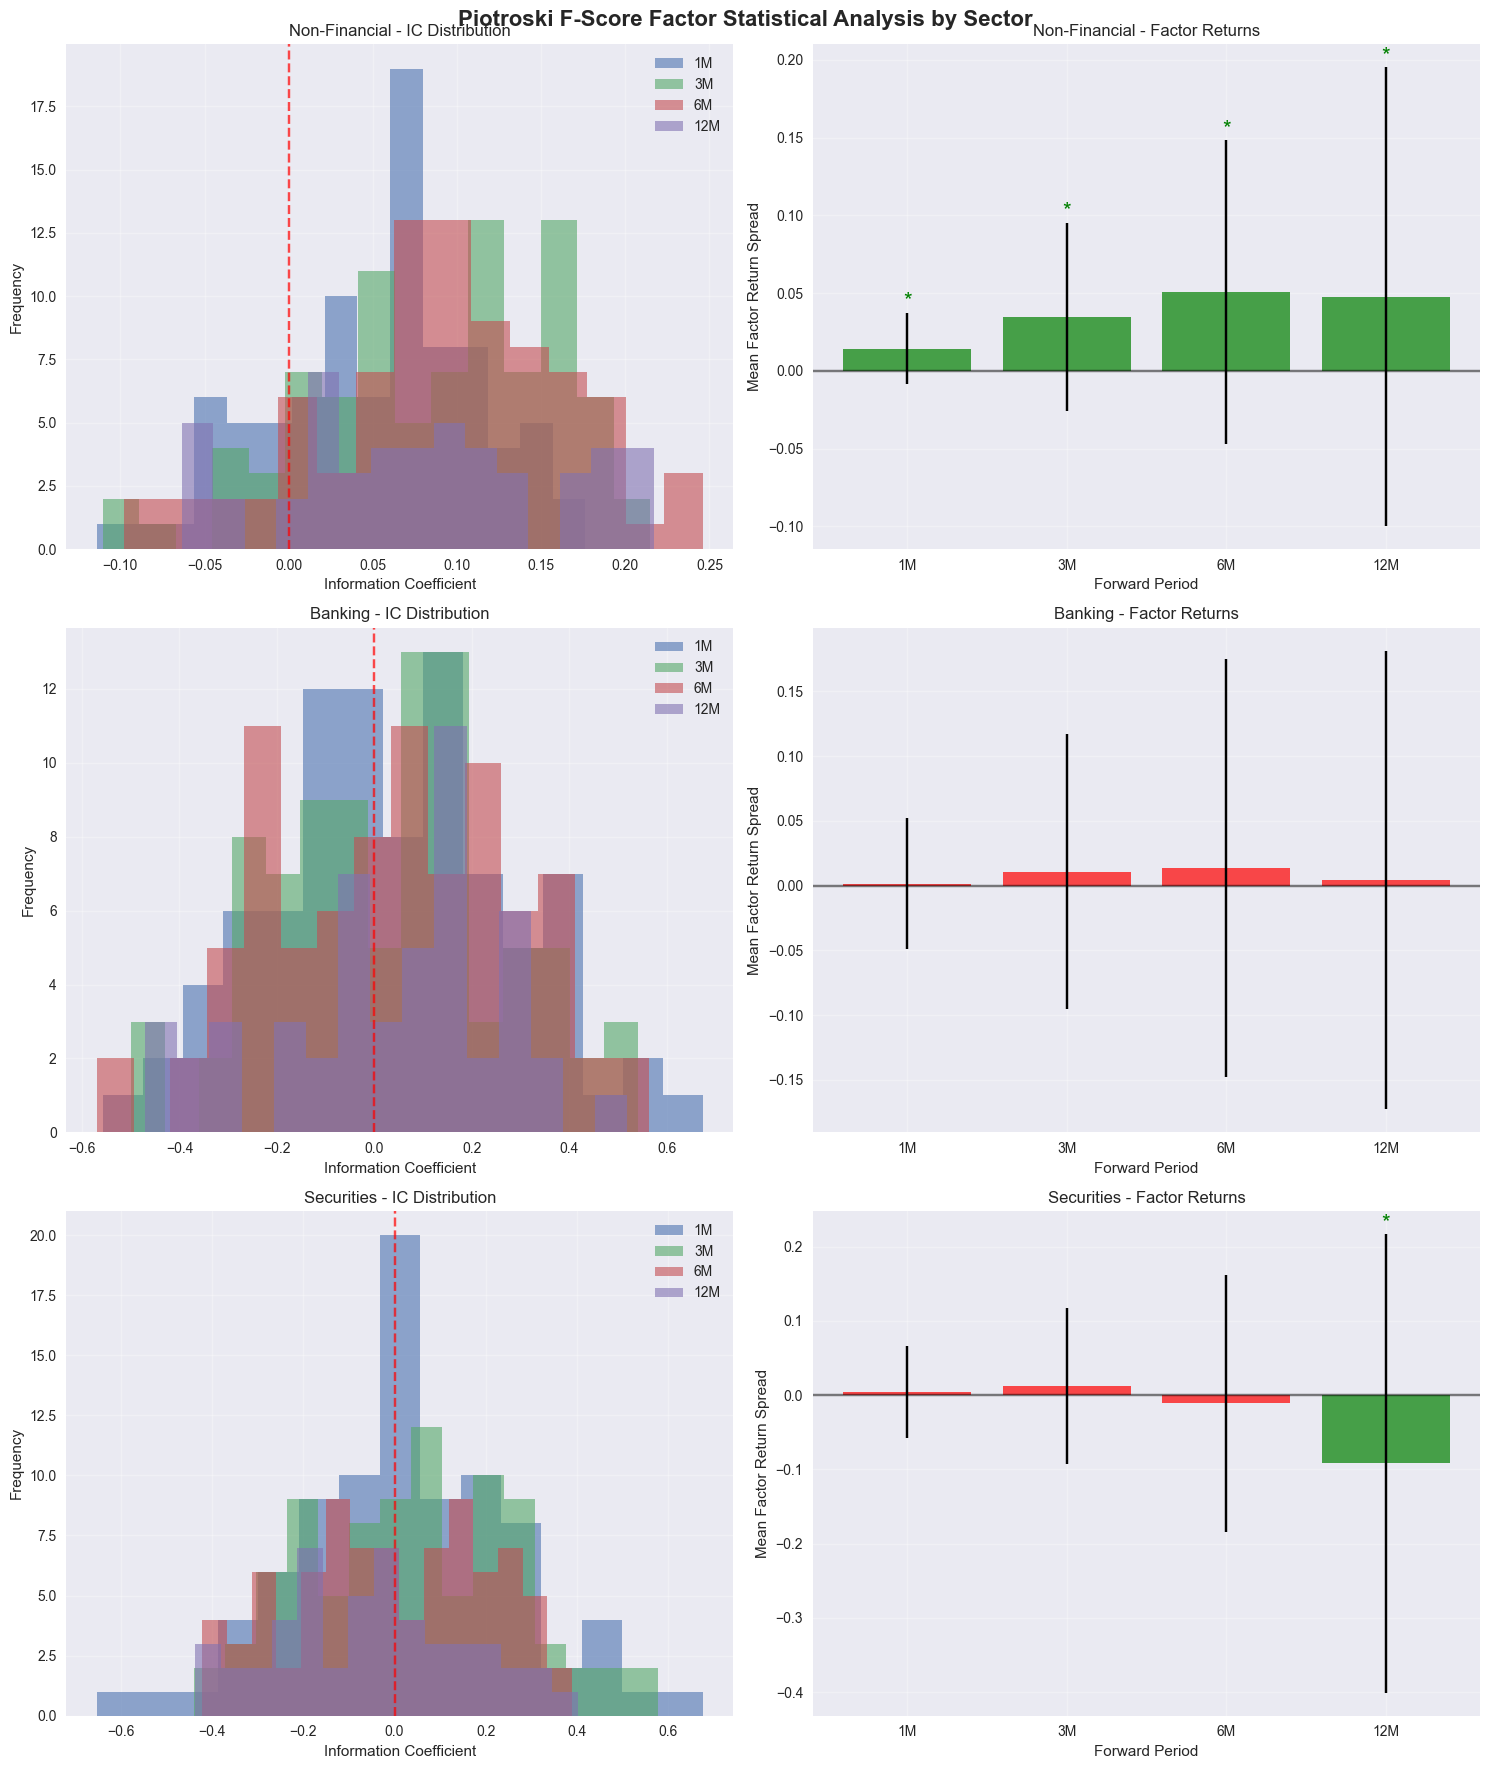

In [28]:
# Debug: Check if we have data to plot
print("DEBUG: Checking data availability for visualization...")
print("=" * 60)

for sector in sectors:
    print(f"\n{sector.upper().replace('_', ' ')} SECTOR:")
    print(f"  Historical F-Score dates: {len(historical_f_score[sector])}")
    print(f"  Historical Forward Returns dates: {len(historical_forward_returns[sector])}")
    
    for period in [1, 3, 6, 12]:
        ic_count = len(ic_results[sector][period]) if ic_results[sector][period] else 0
        returns_count = len(factor_returns_results[sector][period]['returns']) if period in factor_returns_results[sector] else 0
        print(f"    {period}M Forward: IC data points = {ic_count}, Returns data points = {returns_count}")

# Set up plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Piotroski F-Score Factor Statistical Analysis by Sector', fontsize=16, fontweight='bold')

sector_names = {
    'non_financial': 'Non-Financial',
    'banking': 'Banking', 
    'securities': 'Securities'
}

for i, sector in enumerate(sectors):
    # Plot 1: IC Distribution
    ax1 = axes[i, 0]
    has_ic_data = False
    for period in [1, 3, 6, 12]:
        if ic_results[sector][period] and len(ic_results[sector][period]) > 0:
            ax1.hist(ic_results[sector][period], alpha=0.6, label=f'{period}M', bins=15)
            has_ic_data = True
    
    if has_ic_data:
        ax1.axvline(0, color='red', linestyle='--', alpha=0.7)
        ax1.set_xlabel('Information Coefficient')
        ax1.set_ylabel('Frequency')
        ax1.set_title(f'{sector_names[sector]} - IC Distribution')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, f'No IC data available\nfor {sector_names[sector]}', 
                ha='center', va='center', transform=ax1.transAxes, fontsize=12)
        ax1.set_title(f'{sector_names[sector]} - IC Distribution (No Data)')
    
    # Plot 2: Factor Returns Summary
    ax2 = axes[i, 1]
    periods = [p for p in [1, 3, 6, 12] if p in factor_returns_results[sector] and factor_returns_results[sector][p]['returns']]
    
    if periods:
        means = [factor_returns_results[sector][p]['mean_return'] for p in periods]
        stds = [factor_returns_results[sector][p]['std_return'] for p in periods]
        colors = ['green' if factor_returns_results[sector][p]['p_value'] < 0.05 else 'red' for p in periods]
        
        bars = ax2.bar([str(p) + 'M' for p in periods], means, yerr=stds, capsize=5, color=colors, alpha=0.7)
        ax2.axhline(0, color='black', linestyle='-', alpha=0.5)
        ax2.set_xlabel('Forward Period')
        ax2.set_ylabel('Mean Factor Return Spread')
        ax2.set_title(f'{sector_names[sector]} - Factor Returns')
        ax2.grid(True, alpha=0.3)
        
        # Add significance annotations
        for j, (period, results) in enumerate(factor_returns_results[sector].items()):
            if results['p_value'] < 0.05:
                ax2.text(j, means[j] + stds[j] + 0.001, '*', ha='center', va='bottom', fontsize=16, color='green')
    else:
        ax2.text(0.5, 0.5, f'No factor returns data\navailable for {sector_names[sector]}', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title(f'{sector_names[sector]} - Factor Returns (No Data)')

plt.tight_layout()
plt.show()

# DATA AVAILABILITY SUMMARY

In [29]:
print("=" * 80)
print("DATA AVAILABILITY SUMMARY FOR VISUALIZATION")
print("=" * 80)

total_data_points = 0
for sector in sectors:
    print(f"\n{sector.upper().replace('_', ' ')} SECTOR:")
    sector_data_points = 0
    
    for period in [1, 3, 6, 12]:
        ic_count = len(ic_results[sector][period]) if ic_results[sector][period] else 0
        returns_count = len(factor_returns_results[sector][period]['returns']) if period in factor_returns_results[sector] else 0
        sector_data_points += ic_count + returns_count
        
        print(f"  {period}M Forward Period:")
        print(f"    IC data points: {ic_count}")
        print(f"    Returns data points: {returns_count}")
    
    print(f"  Total data points: {sector_data_points}")
    total_data_points += sector_data_points

print(f"\nOVERALL SUMMARY:")
print(f"  Total data points across all sectors: {total_data_points}")
if total_data_points == 0:
    print("  ⚠️  NO DATA AVAILABLE - This is likely due to:")
    print("     - Database schema issues (missing columns like 'roa', 'cfo', etc.)")
    print("     - No financial data available for the specified dates")
    print("     - Database connection issues")
    print("  🔧 RECOMMENDATION: Check database schema and data availability")
else:
    print("  ✅ Data available for visualization")

DATA AVAILABILITY SUMMARY FOR VISUALIZATION

NON FINANCIAL SECTOR:
  1M Forward Period:
    IC data points: 87
    Returns data points: 87
  3M Forward Period:
    IC data points: 87
    Returns data points: 87
  6M Forward Period:
    IC data points: 84
    Returns data points: 84
  12M Forward Period:
    IC data points: 50
    Returns data points: 50
  Total data points: 616

BANKING SECTOR:
  1M Forward Period:
    IC data points: 87
    Returns data points: 87
  3M Forward Period:
    IC data points: 87
    Returns data points: 87
  6M Forward Period:
    IC data points: 84
    Returns data points: 84
  12M Forward Period:
    IC data points: 50
    Returns data points: 50
  Total data points: 616

SECURITIES SECTOR:
  1M Forward Period:
    IC data points: 87
    Returns data points: 87
  3M Forward Period:
    IC data points: 87
    Returns data points: 87
  6M Forward Period:
    IC data points: 84
    Returns data points: 84
  12M Forward Period:
    IC data points: 50
    Ret

# SUMMARY AND CONCLUSIONS BY SECTOR

In [30]:
print("=" * 100)
print("PIOTROSKI F-SCORE FACTOR STATISTICAL SIGNIFICANCE SUMMARY BY SECTOR")
print("=" * 100)

print("\n📊 KEY FINDINGS BY SECTOR:")
print("-" * 50)

for sector in sectors:
    print(f"\n{sector.upper().replace('_', ' ')} SECTOR:")
    print("-" * 30)
    
    # IC Analysis Summary
    print("\n1. INFORMATION COEFFICIENT ANALYSIS:")
    significant_ic_count = 0
    for period in [1, 3, 6, 12]:
        if period in ic_stats[sector]:
            stats = ic_stats[sector][period]
            significance = "✅ STATISTICALLY SIGNIFICANT" if stats['p_value'] < 0.05 else "❌ NOT SIGNIFICANT"
            print(f"   {period}M Forward: IC = {stats['mean']:.4f} (p = {stats['p_value']:.4f}) - {significance}")
            if stats['p_value'] < 0.05:
                significant_ic_count += 1
    
    # Factor Returns Summary
    print("\n2. FACTOR RETURNS ANALYSIS:")
    significant_returns_count = 0
    for period in [1, 3, 6, 12]:
        if period in factor_returns_results[sector]:
            results = factor_returns_results[sector][period]
            significance = "✅ STATISTICALLY SIGNIFICANT" if results['p_value'] < 0.05 else "❌ NOT SIGNIFICANT"
            print(f"   {period}M Forward: Spread = {results['mean_return']:.4f} (p = {results['p_value']:.4f}) - {significance}")
            if results['p_value'] < 0.05:
                significant_returns_count += 1
    
    # Sector Assessment
    print(f"\n3. SECTOR ASSESSMENT:")
    print(f"   - IC Significance: {significant_ic_count}/4 periods significant")
    print(f"   - Returns Significance: {significant_returns_count}/4 periods significant")
    
    if significant_ic_count >= 2 and significant_returns_count >= 2:
        print(f"   🎯 CONCLUSION: {sector_names[sector]} F-Score shows strong statistical significance")
        print(f"   ✅ RECOMMENDATION: Include in QVM v2.1 Alpha strategy")
    else:
        print(f"   ⚠️ CONCLUSION: {sector_names[sector]} F-Score shows mixed statistical significance")
        print(f"   🔍 RECOMMENDATION: Further analysis needed before inclusion")

# Overall Assessment
print(f"\n" + "=" * 100)
print("OVERALL ASSESSMENT:")
print("=" * 100)

total_significant_sectors = 0
for sector in sectors:
    significant_ic = sum(1 for period in [1, 3, 6, 12] if period in ic_stats[sector] and ic_stats[sector][period]['p_value'] < 0.05)
    significant_returns = sum(1 for period in [1, 3, 6, 12] if period in factor_returns_results[sector] and factor_returns_results[sector][period]['p_value'] < 0.05)
    
    if significant_ic >= 2 and significant_returns >= 2:
        total_significant_sectors += 1

print(f"   - Sectors with strong significance: {total_significant_sectors}/{len(sectors)}")
print(f"   - Overall F-Score effectiveness: {'✅ HIGH' if total_significant_sectors >= 2 else '⚠️ MIXED' if total_significant_sectors >= 1 else '❌ LOW'}")

if total_significant_sectors >= 2:
    print("   🎯 FINAL CONCLUSION: Piotroski F-Score factor shows strong statistical significance across sectors")
    print("   ✅ FINAL RECOMMENDATION: Include in QVM v2.1 Alpha strategy with sector-specific implementation")
else:
    print("   ⚠️ FINAL CONCLUSION: Piotroski F-Score factor shows limited statistical significance")
    print("   🔍 FINAL RECOMMENDATION: Further refinement needed before inclusion")

print("\n" + "=" * 100) 

PIOTROSKI F-SCORE FACTOR STATISTICAL SIGNIFICANCE SUMMARY BY SECTOR

📊 KEY FINDINGS BY SECTOR:
--------------------------------------------------

NON FINANCIAL SECTOR:
------------------------------

1. INFORMATION COEFFICIENT ANALYSIS:
   1M Forward: IC = 0.0515 (p = 0.0000) - ✅ STATISTICALLY SIGNIFICANT
   3M Forward: IC = 0.0848 (p = 0.0000) - ✅ STATISTICALLY SIGNIFICANT
   6M Forward: IC = 0.0920 (p = 0.0000) - ✅ STATISTICALLY SIGNIFICANT
   12M Forward: IC = 0.0785 (p = 0.0000) - ✅ STATISTICALLY SIGNIFICANT

2. FACTOR RETURNS ANALYSIS:
   1M Forward: Spread = 0.0144 (p = 0.0000) - ✅ STATISTICALLY SIGNIFICANT
   3M Forward: Spread = 0.0346 (p = 0.0000) - ✅ STATISTICALLY SIGNIFICANT
   6M Forward: Spread = 0.0505 (p = 0.0000) - ✅ STATISTICALLY SIGNIFICANT
   12M Forward: Spread = 0.0476 (p = 0.0238) - ✅ STATISTICALLY SIGNIFICANT

3. SECTOR ASSESSMENT:
   - IC Significance: 4/4 periods significant
   - Returns Significance: 4/4 periods significant
   🎯 CONCLUSION: Non-Financial F-Sc